In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import os
import numpy as np
from scipy.special import logsumexp
from sklearn.feature_extraction.text import CountVectorizer

import re
from html.parser import HTMLParser
from sklearn.feature_extraction.text import CountVectorizer

def preprocess_documents(documents):
    # Define a function to remove HTML tags
    class HTMLTagRemover(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs = True
            self.fed = []

        def handle_data(self, d):
            self.fed.append(d)

        def get_data(self):
            return ''.join(self.fed)

    # Define a regular expression pattern for removing numbers, underscores, and other unnecessary characters
    number_pattern = r'\b\d+\b'
    char_pattern = r'[\W_]+'

    # Initialize the vectorizer
    vectorizer = CountVectorizer()

    # Remove numbers, HTML tags, underscores, and other unnecessary characters from each document
    preprocessed_documents = []
    for document in documents:
        # Remove HTML tags
        tag_remover = HTMLTagRemover()
        tag_remover.feed(document)
        document = tag_remover.get_data()

        # Remove numbers
        document = re.sub(number_pattern, '', document)

        # Remove underscores and other unnecessary characters
        document = re.sub(char_pattern, ' ', document)

        # Perform additional preprocessing as needed (e.g., removing special characters, stopwords)

        # Add the preprocessed document to the list
        preprocessed_documents.append(document)

    # Generate the document-term matrix
    X = vectorizer.fit_transform(preprocessed_documents)
    V = vectorizer.get_feature_names()
    beta = 100  # Word vector dimensionality
    R = np.random.randn(beta, len(V))
    b = np.random.randn(len(V))
    theta = np.random.randn(beta)
    return V, beta, R, b, theta




class SemanticSimilaritiesModel:
    def __init__(self, beta, V, R, b, theta, lambd=0.1, nu=0.1):
        self.beta = beta
        self.V = V
        self.R = R
        self.b = b
        self.theta = theta
        self.lambd = lambd
        self.nu = nu

    def compute_energy(self, w, theta, phi_w, b_w):
        return -np.dot(theta, phi_w) - b_w

    def compute_word_probabilities(self, theta, R, b):
        energy = np.dot(R.T, theta) + b
        log_probabilities = energy - logsumexp(energy)
        return np.exp(log_probabilities)

    def compute_document_probability(self, document):
        word_indices = [self.V.index(word.lower()) for word in document.lower().split() if word.lower() in self.V]
        word_probabilities = [self.compute_word_probabilities(self.theta, self.R[:, i], self.b[i])
                              for i in word_indices]
        return np.prod(word_probabilities)

    def compute_log_likelihood(self, documents):
        log_likelihood = 0.0
        for document in documents:
            log_likelihood += np.sum(np.log(self.compute_document_probability(document)))
        return log_likelihood

    def compute_regularization_term(self):
        return self.nu * np.linalg.norm(self.R) ** 2

    def compute_objective(self, documents):
        log_likelihood = self.compute_log_likelihood(documents)
        regularization_term = self.compute_regularization_term()
        return log_likelihood + regularization_term

    def optimize_parameters(self, documents, batch_size=32, max_iterations=100, learning_rate=0.1):
        num_documents = len(documents)
        num_batches = (num_documents + batch_size - 1) // batch_size

        # Precompute word indices and probabilities for all documents
        word_indices = [[self.V.index(word.lower()) for word in document.split() if word.lower() in self.V]
                        for document in documents]
        word_probabilities = [[self.compute_word_probabilities(self.theta, self.R[:, i], self.b[i])
                                for i in indices] for indices in word_indices]

        for iteration in range(max_iterations):
            total_gradient_R = np.zeros((self.beta, len(self.V)))
            total_gradient_b = np.zeros(len(self.V))
            total_gradient_theta = np.zeros(self.beta)

            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, num_documents)
                batch_documents = documents[start_idx:end_idx]
                batch_word_indices = word_indices[start_idx:end_idx]
                batch_word_probabilities = word_probabilities[start_idx:end_idx]

                gradient_R = np.zeros((self.beta, len(self.V)))
                gradient_b = np.zeros(len(self.V))
                gradient_theta = np.zeros(self.beta)

                for doc_indices, doc_probs in zip(batch_word_indices, batch_word_probabilities):
                    unique_doc_indices = np.unique(doc_indices)
                    gradients = self.compute_gradients(unique_doc_indices, doc_probs)
                    mask = np.zeros((self.beta, len(self.V)))
                    mask[:, unique_doc_indices] = 1
                    gradient_R += gradients[0] * mask
                    gradient_b += gradients[1] * mask[0]
                    gradient_theta += gradients[2]


                total_gradient_R += gradient_R
                total_gradient_b += gradient_b
                total_gradient_theta += gradient_theta
                print("batch: ",batch)

            self.R -= learning_rate * (total_gradient_R + 2 * self.nu * self.R)
            self.b -= learning_rate * total_gradient_b
            self.theta -= learning_rate * (total_gradient_theta + 2 * self.lambd * self.theta)

            objective = self.compute_objective(documents)
            print(f"Iteration {iteration+1}: Objective = {objective}")

    def compute_gradients(self, word_indices, word_probabilities):
        gradient_R = np.zeros((self.beta, len(self.V)))
        gradient_b = np.zeros(len(self.V))
        

        gradient_theta = np.zeros(self.beta)

        for indices, prob_w in zip(word_indices, word_probabilities):
            phi_w = self.R[:, indices]
            b_w = self.b[indices]
            gradient_R[:, indices] += (prob_w - 1) * self.theta
            gradient_b[indices] += prob_w - 1
            gradient_theta += prob_w * phi_w
        return gradient_R, gradient_b, gradient_theta


    def compute_document_similarity(self, document1, document2):
        representation1 = self.compute_document_representation(document1)
        representation2 = self.compute_document_representation(document2)
        similarity = np.dot(representation1, representation2) / (np.linalg.norm(representation1) * np.linalg.norm(representation2))
        return similarity
    
  


    def compute_document_representation(self, document):
        word_indices = [self.V.index(word.lower()) for word in document.split() if word.lower() in self.V]
        document_representation = np.zeros(self.beta)
        for word_index in word_indices:
            phi_w = self.R[:, word_index]
            b_w = self.b[word_index]
            word_probabilities = self.compute_word_probabilities(self.theta, phi_w, b_w)
            document_representation += word_probabilities * phi_w
        return document_representation







In [10]:
# Read and preprocess the dataset
folder_path = 'unsup'
documents = []
i=0
for file_name in os.listdir(folder_path):
    # if i>=1000:
    #     break
    # i+=1
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        document = file.read()
        documents.append(document)

V, beta, R, b, theta = preprocess_documents(documents)

print('V: ',V,'\nbeta: ',beta,'\nR: ',R,'\ntheta: ',theta,'\nb: ',b)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


V:  ['000ft', '000th', '0091042clueless', '00am', '00o', '00pm', '00s', '01p', '05in', '06p', '07am', '07i', '09many', '0f', '0n', '0ne', '0one', '0out', '0r', '0s', '1000s', '1000th', '1000x', '100feet', '100ft', '100k', '100lb', '100m', '100million', '100min', '100mins', '100mph', '100s', '100th', '100x', '100yr', '101st', '103rd', '1080p', '10a', '10actors', '10all', '10also', '10am', '10another', '10as', '10b', '10because', '10bobby', '10brilliance', '10bscdb', '10camp', '10cat', '10cc', '10character', '10check', '10cheesiness', '10city', '10cr', '10dance', '10delton', '10direction', '10disclaimer', '10dm', '10do', '10don', '10edge', '10eight', '10enjoy', '10ers', '10fifth', '10fight', '10fourth', '10fx', '10g', '10go', '10god', '10good', '10have', '10http', '10i', '10if', '10images', '10is', '10ishq', '10jane', '10k', '10kane', '10lady', '10m', '10match', '10millionth', '10min', '10minutes', '10mpaa', '10mph', '10not', '10o', '10overall', '10p', '10pm', '10post', '10ps', '10qualit

In [11]:
# Create an instance of the SemanticSimilaritiesModel class
model = SemanticSimilaritiesModel(beta, V, R, b, theta)

In [ ]:
# Optimize the parameters
model.optimize_parameters(documents, batch_size=32, max_iterations=3, learning_rate=0.1)

In [12]:
document1 = "I like dogs"
document2 = "I eat  bones"
similarity = model.compute_document_similarity(document1, document2)
print(f"Semantic similarity between document1 and document2: {similarity}")


Semantic similarity between document1 and document2: -0.06364668131149837


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Define the batch size for cosine similarity calculation
batch_size = 1000

# Define the number of similar words to display for each word
num_similar_words = 5

# Iterate over the vocabulary and find similar words for each word
similar_words = {}
num_batches = len(V) // batch_size + 1
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(V))

    # Calculate cosine similarity for the current batch
    batch_vectors = R[:, start_idx:end_idx].T
    batch_similarities = cosine_similarity(batch_vectors, batch_vectors)

    # Find similar words for each word in the batch
    for j in range(start_idx, end_idx):
        word = V[j]
        similarities = batch_similarities[j - start_idx]
        similar_indices = np.argsort(similarities)[-num_similar_words:][::-1]
        similar_words.setdefault(word, []).extend([V[idx] for idx in similar_indices])

# Print the similar words for each word
for word, similar in similar_words.items():
    print(f"{word}: {', '.join(similar)}")


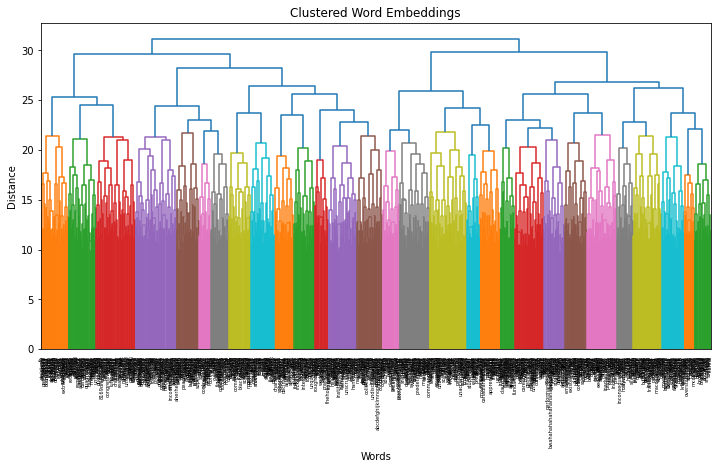

In [15]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def visualize_clustered_embeddings(R, V, num_samples=1000):
    # Randomly select a subset of the data
    indices = np.random.choice(len(V), size=num_samples, replace=False)
    R_subset = R[:, indices]
    V_subset = [V[i] for i in indices]

    Z = linkage(R_subset.T, method='ward')

    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=V_subset, leaf_rotation=90)
    plt.title('Clustered Word Embeddings')
    plt.xlabel('Words')
    plt.ylabel('Distance')
    plt.show()


# After the optimization step

# Visualize clustered word embeddings with a subset of data
num_samples = 1000  # Specify the number of samples to visualize
visualize_clustered_embeddings(model.R, model.V, num_samples)


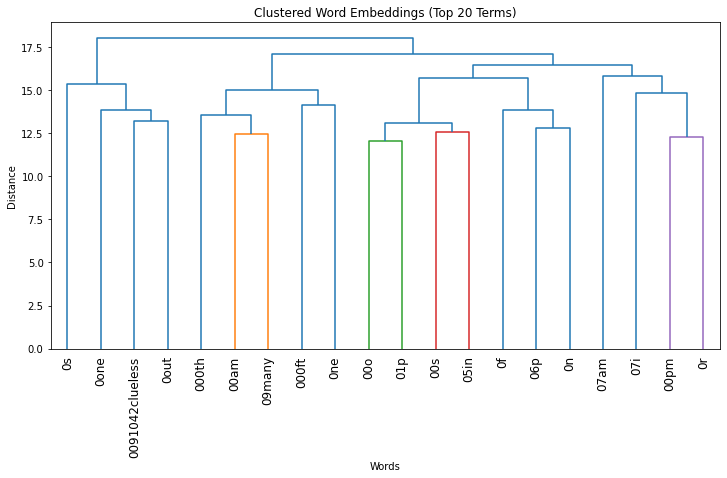

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


def visualize_clustered_embeddings(R, V, num_terms=20):
    top_terms = V[:num_terms]
    top_embeddings = R[:, :num_terms].T
    Z = linkage(top_embeddings, method='ward')

    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=top_terms, leaf_rotation=90)
    plt.title('Clustered Word Embeddings (Top 20 Terms)')
    plt.xlabel('Words')
    plt.ylabel('Distance')
    plt.show()


# After the optimization step

# Visualize clustered word embeddings for top 20 terms
visualize_clustered_embeddings(model.R, model.V, num_terms=20)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_similarity_heatmap(R, V):
    similarity_matrix = np.dot(R.T, R)

    plt.figure(figsize=(10, 10))
    sns.heatmap(similarity_matrix, xticklabels=V, yticklabels=V, cmap='YlGnBu')
    plt.title('Word Embedding Similarity Heatmap')
    plt.xlabel('Words')
    plt.ylabel('Words')
    plt.show()


# After the optimization step

# Visualize similarity heatmap of word embeddings
visualize_similarity_heatmap(model.R, model.V)


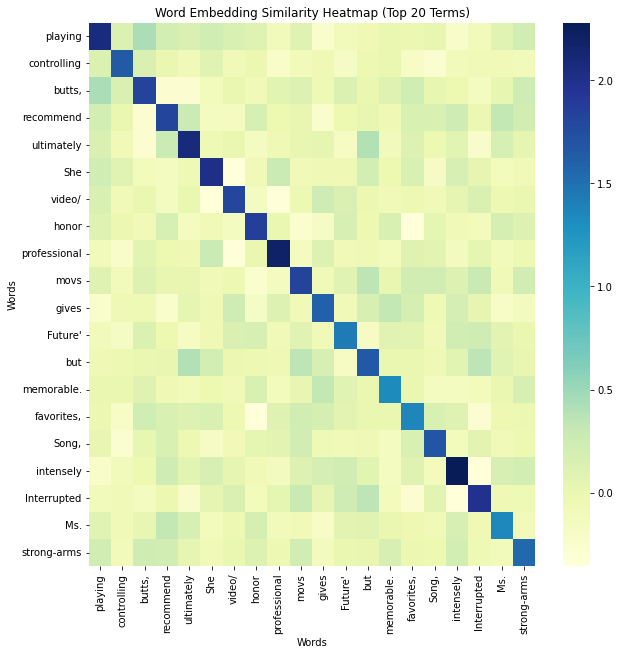

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_similarity_heatmap(R, V, num_terms=20):
    top_terms = V[:num_terms]
    top_embeddings = R[:, :num_terms]
    similarity_matrix = np.dot(top_embeddings.T, top_embeddings)

    plt.figure(figsize=(10, 10))
    sns.heatmap(similarity_matrix, xticklabels=top_terms, yticklabels=top_terms, cmap='YlGnBu')
    plt.title('Word Embedding Similarity Heatmap (Top 20 Terms)')
    plt.xlabel('Words')
    plt.ylabel('Words')
    plt.show()


# After the optimization step

# Visualize similarity heatmap of word embeddings for top 20 terms
visualize_similarity_heatmap(model.R, model.V, num_terms=20)


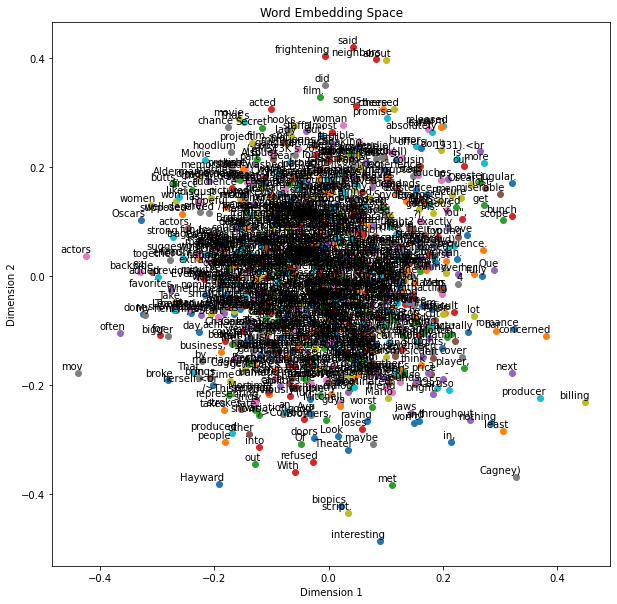

In [ ]:
import matplotlib.pyplot as plt


def visualize_word_embedding_space(R, V):
    word_embeddings = R.T

    plt.figure(figsize=(10, 10))
    for i, word in enumerate(V):
        x, y = word_embeddings[i][:2]  # Retrieve the first two dimensions
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()



# After the optimization step

# Visualize word embedding space
visualize_word_embedding_space(model.R, model.V)


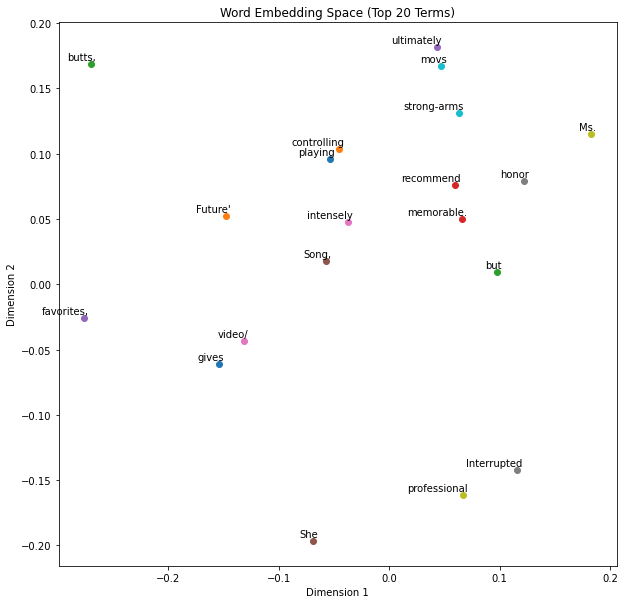

In [ ]:
import matplotlib.pyplot as plt


def visualize_word_embedding_space(R, V, num_terms=20):
    word_embeddings = R.T

    plt.figure(figsize=(10, 10))
    for i in range(num_terms):
        word = V[i]
        x, y = word_embeddings[i][:2]  # Retrieve the first two dimensions
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embedding Space (Top 20 Terms)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


# After the optimization step

# Visualize word embedding space for top 20 terms
visualize_word_embedding_space(model.R, model.V, num_terms=20)


In [ ]:
# import os
# import numpy as np
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# def preprocess_reviews(folder_path):
#     documents = []
#     labels = []
#     for label in ['neg', 'pos']:
#         label_folder = os.path.join(folder_path, label)
#         for file_name in os.listdir(label_folder):
#             file_path = os.path.join(label_folder, file_name)
#             with open(file_path, 'r', encoding='utf-8') as file:
#                 document = file.read()
#                 documents.append(document)
#                 labels.append(label)
#     return documents, labels


# def predict_sentiment(review, model):
#     words = review.split()
#     probabilities = []
#     for word in words:
#         try:
#             word_index = model.V.index(word)
#             phi_w = model.R[:, word_index]
#             b_w = model.b[word_index]
#             probability = model.compute_word_probabilities(model.theta, phi_w, b_w)
#             probabilities.append(probability)
#         except ValueError:
#             # Handle out-of-vocabulary words
#             probabilities.append(0.5)  # Assume equal probability for unknown words

#     average_probability = np.mean(probabilities)
#     if average_probability >= 0.5:
#         return 'pos'
#     else:
#         return 'neg'



In [ ]:
# test_folder_path = 'MoveReview\\aclImdb\\train\\'  
# test_documents, test_labels = preprocess_reviews(test_folder_path)

# predictions = [predict_sentiment(document, model) for document in test_documents]

# accuracy = accuracy_score(test_labels, predictions)
# print('Accuracy:', accuracy)

# confusion = confusion_matrix(test_labels, predictions)
# print('Confusion Matrix:')
# print(confusion)

# classification = classification_report(test_labels, predictions)
# print('Classification Report:')
# print(classification)
